<h1>CSC8635 Machine Learning Extended Technical Report</h1>
<h2>What is the need for the project?</h2>
<p>'Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small
size and lack of diversity of available datasets of dermatoscopic images.' (Tschandl, Rosendahl and Kittler, 2018). In this project, I will be exploring various machine learning models and running a comparison between them in order to choose a suitable model </p>

<h2>What did I do?</h2>
<p>Due to the limited time availible for the project and often massive runtimes of each model, only a few models were able to be compared. In this particular instance, I compared a Convolutional Neural Network, a pre-defined neural network by VGG and Logistic Regression. </p>

In [1]:
# Sources used to help produce code
# https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
# https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy?fbclid=IwAR2JWtc6_nC3PZwfg5THA1qjTx1qaLc6NllbXIAftRkZQu_AnQ6VMgaDsIs
# https://engmrk.com/vgg16-implementation-using-keras/

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras import applications
from sklearn.linear_model import LogisticRegression
from keras.layers import MaxPooling2D

Using TensorFlow backend.


In [2]:
# get working directory
cwd = os.getcwd()
print(cwd)

C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src


<h3>Data Cleaning and Preprocessing</h3>
<p>

In [3]:
# change working directory to import data
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

In [4]:
metadata_df = pd.read_csv("HAM10000_metadata.csv")

In [5]:
# dictionary for image paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('*', '*.jpg'))}

In [6]:
# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

In [7]:
# dictionary to rename cell types for readability
lesion_type_dict = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratosis-like Lesions ',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Bowens Disease',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

In [8]:
# add column for path of image
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
# add column for cell types, for readability
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
# assign each cell type an ID and add it to a column
metadata_df['cell_type_id'] = pd.Categorical(metadata_df['cell_type']).codes

In [9]:
# print first 5 values of dataframe
print(metadata_df.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                      path                       cell_type  \
0  HAM10000_images_part_1\ISIC_0027419.jpg  Benign Keratosis-like Lesions    
1  HAM10000_images_part_1\ISIC_0025030.jpg  Benign Keratosis-like Lesions    
2  HAM10000_images_part_1\ISIC_0026769.jpg  Benign Keratosis-like Lesions    
3  HAM10000_images_part_1\ISIC_0025661.jpg  Benign Keratosis-like Lesions    
4  HAM10000_images_part_2\ISIC_0031633.jpg  Benign Keratosis-like Lesions    

   cell_type_id  
0             1  
1             1  
2             1  
3             1  
4             1  


In [10]:
# print first 5 values of dataframe
print(metadata_df.tail(5))

         lesion_id      image_id     dx dx_type   age     sex localization  \
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                          path       cell_type  cell_type_id  
10010  HAM10000_images_part_2\ISIC_0033084.jpg  Bowens Disease             2  
10011  HAM10000_images_part_2\ISIC_0033550.jpg  Bowens Disease             2  
10012  HAM10000_images_part_2\ISIC_0033536.jpg  Bowens Disease             2  
10013  HAM10000_images_part_2\ISIC_0032854.jpg  Bowens Disease             2  
10014  HAM10000_images_part_2\ISIC_0032258.jpg        Melanoma             5  


<p>This allows us to see the first and last 5 values of the metadata dataset, and get a general understanding of how the data is formatted.</p>

In [11]:
# print column names
print(metadata_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_id'],
      dtype='object')


In [12]:
# summary of numeric values
print(metadata_df.describe())

               age  cell_type_id
count  9958.000000  10015.000000
mean     51.863828      3.528208
std      16.968614      1.377071
min       0.000000      0.000000
25%      40.000000      4.000000
50%      50.000000      4.000000
75%      65.000000      4.000000
max      85.000000      6.000000


<p>While the mean age is calculated as 52, as the ages in the dataset are given in intervals of 5, this may not actually be a true representation of the ages. However, for our purposes with the dataset as long as the age is kept consistent throughout this is not a large issue, although in order to get a more precise model in a future project it may help to give the exact ages.</p>

<p>For data cleaning, it is often important to deal with null/NA values from data to remove redundant rows from the dataset. In this situation, as age was the oncly column with null values I opted to replace them with the mean value of the age column. In order to improve accuracy further, it may be worthwhile in a future project to look at other factors that my affect age and calculate the age based of of that e.g. are certain ages more likely to have a certain cell type? While not null values, I removed any rows that had unknown values (prevalent in the sex and localization columns).</p>

In [13]:
# gives us data types and how many values of each column are non-null
print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
path            10015 non-null object
cell_type       10015 non-null object
cell_type_id    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB
None


In [14]:
# fill null values of age with the mean value of the age column
metadata_df["age"] = metadata_df["age"].fillna(int(metadata_df["age"].mean()))

In [15]:
# display unique values in cell type column
print(metadata_df.dx.unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [16]:
# display unique values in diagnosis column
print(metadata_df.dx_type.unique())

['histo' 'consensus' 'confocal' 'follow_up']


In [17]:
# display unique values in sex column
print(metadata_df.sex.unique())

['male' 'female' 'unknown']


In [18]:
# drop rows where sex = unknown
#metadata_df = metadata_df[metadata_df.sex!='unknown']

In [19]:
# display unique values in sex column
print(metadata_df.localization.unique())

['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']


In [20]:
# drop rows where localization = unknown
#metadata_df = metadata_df[metadata_df.localization!='unknown']

<h3>Exploratory Data Analysis</h3>
<p>In between the data cleaning and preprocessing phase, the data was explored in order to get a further understanding of the dataset and structure.</p>

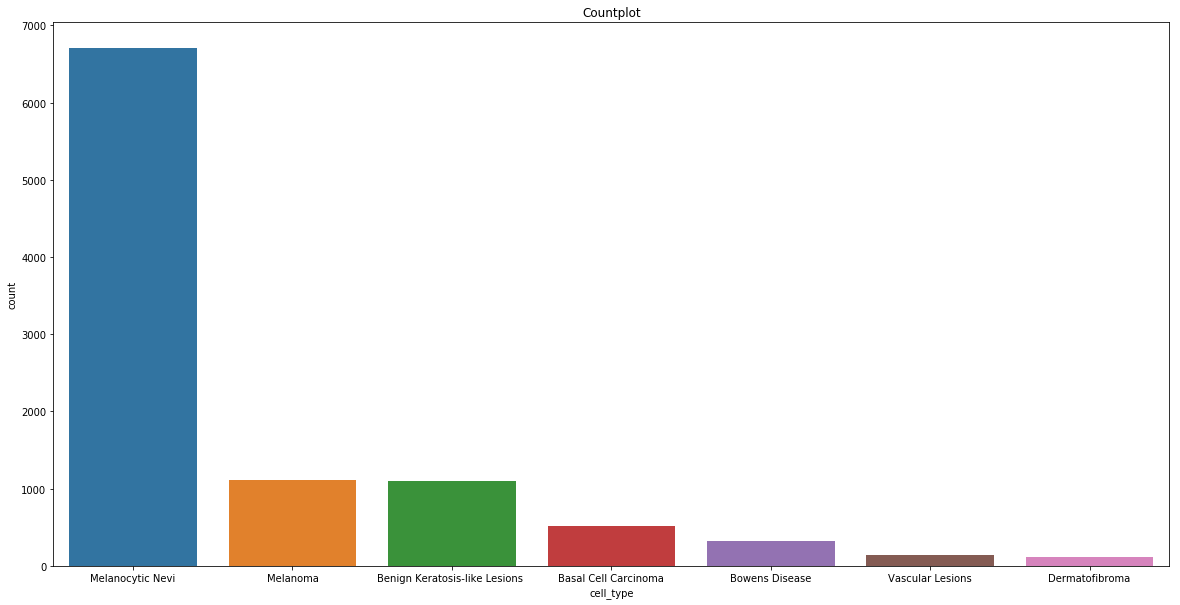

In [21]:
# countplot of cell type
plt.figure(figsize=(20, 10))

sns.countplot(x = 'cell_type',
              data = metadata_df,
              order = metadata_df['cell_type'].value_counts().index)
plt.title("Countplot")
plt.show()

In [22]:
metadata_df.groupby('cell_type').count()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type_id
cell_type,,,,,,,,,
Basal Cell Carcinoma,514,514,514,514,514,514,514,514,514
Benign Keratosis-like Lesions,1099,1099,1099,1099,1099,1099,1099,1099,1099
Bowens Disease,327,327,327,327,327,327,327,327,327
Dermatofibroma,115,115,115,115,115,115,115,115,115
Melanocytic Nevi,6705,6705,6705,6705,6705,6705,6705,6705,6705
Melanoma,1113,1113,1113,1113,1113,1113,1113,1113,1113
Vascular Lesions,142,142,142,142,142,142,142,142,142


<p>Here we can see that there are a much larger amount of Melanocytic Nevi cells than any other type, with approximately 6 times more values then the next most frequent cell, melanoma. The least frequent cell type is Dermatofibroma. This means that there is a huge range of 6384. This is improtant to consider for the machine learning models, as say for example if the model was incorrect and predicted every image as Melanocytic Nevi, it still may result in a relatively high accuracy. This stresses the importance of using a confusion matrix, as it allows me to verify the validity of my results.</p>

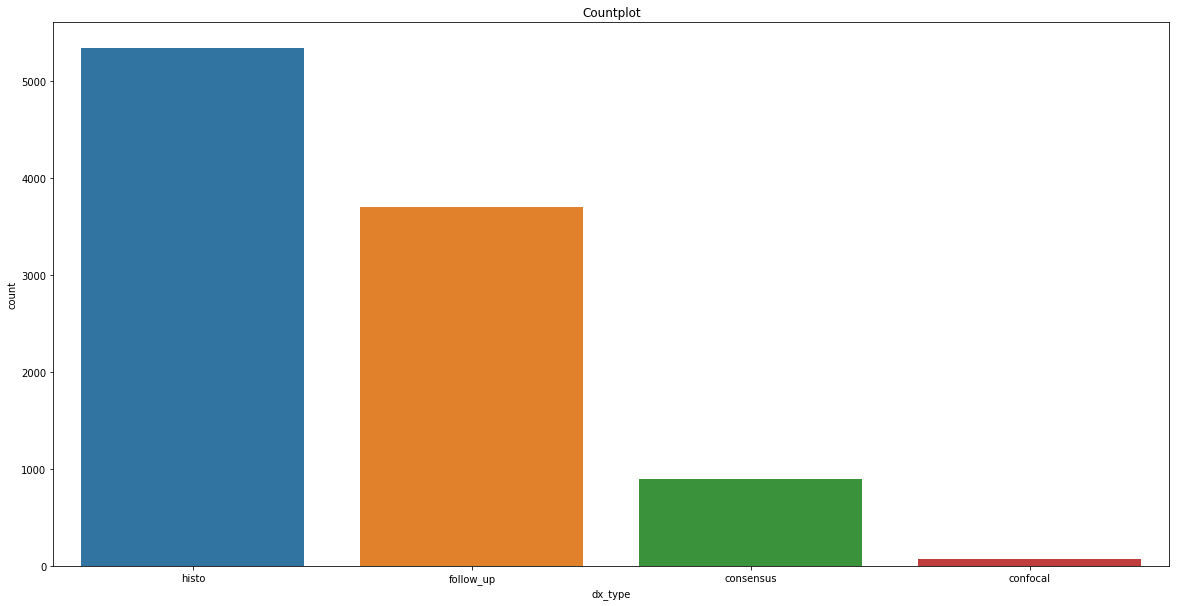

In [23]:
# countplot of diagnosis
plt.figure(figsize=(20, 10))

sns.countplot(x = 'dx_type',
              data = metadata_df,
              order = metadata_df['dx_type'].value_counts().index)
plt.title("Countplot")
plt.show()

<p>A countplot of the diagnosis type was produced, which allows us to see how the Although this will not necessarily affect our results, it is worth noting that this gives us some insights into how the cancer is diagnosed and potential false diagnoses.</p>

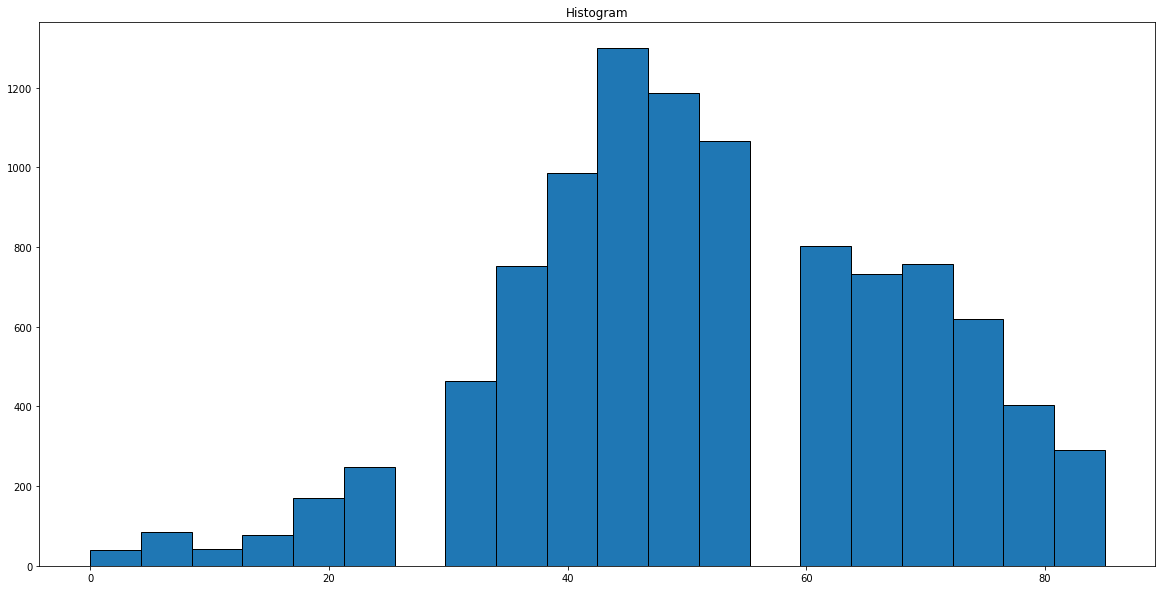

In [24]:
# histogram of age
plt.figure(figsize=(20, 10))

plt.hist(metadata_df['age'], bins = 20, histtype='bar', ec='black')
plt.title("Histogram")
plt.show()

<p>To see the age distribution of the dataset, a histogram was produced. As we can see, the majority of people are in the 40-60 range, with very few people under the age of 20 included in the dataset.</p>

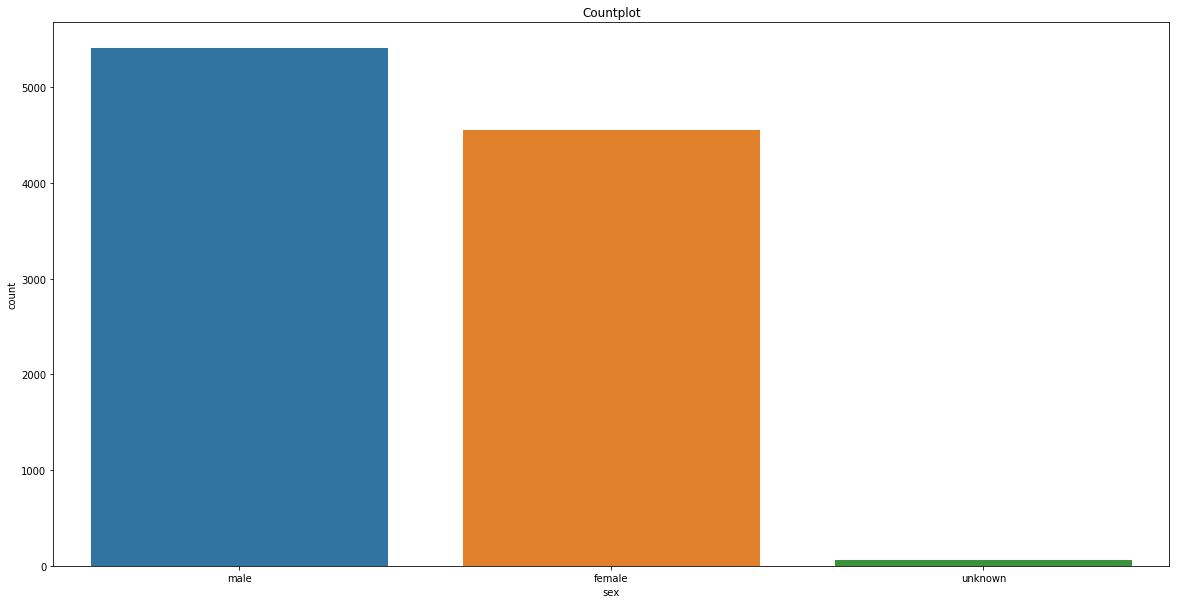

In [25]:
# countplot of sex
plt.figure(figsize=(20, 10))

sns.countplot(x = 'sex',
              data = metadata_df,
              order = metadata_df['sex'].value_counts().index)
plt.title("Countplot")
plt.show()

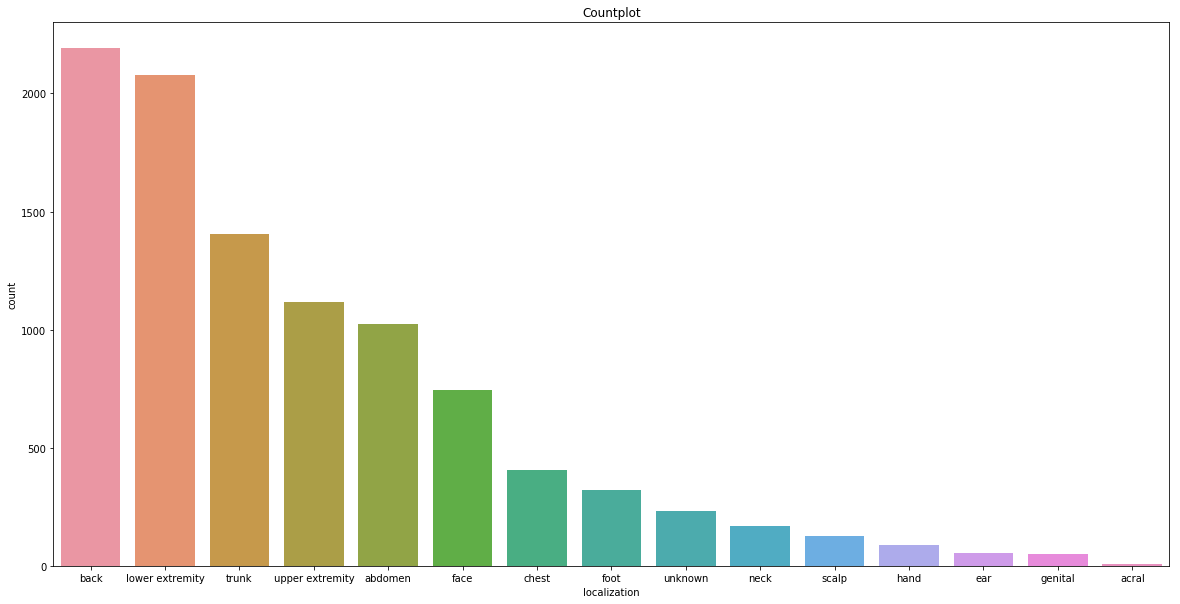

In [26]:
# countplot of loalization
plt.figure(figsize=(20, 10))

sns.countplot(x = 'localization',
              data = metadata_df,
              order = metadata_df['localization'].value_counts().index)
plt.title("Countplot")
plt.show()

<p>While all of the images are the same size and image resizing is not necessary, due to the timescale of the project it was essential for me to make the image sizes smaller to allow for faster run times, although this ultimately could affect the accuracy of the models due to a loss of data in the images. I have therefore tried to balance run time and accuracy, and resized the images to 1/3 of the original size. In the future, given a larger timescale/ better resources I would like to rexplore the dataset using the original image sizes and compare the accuracies and see if there is any significant differences between the original and rescaled images. While not directly applicable to our dataset, it is also important to note that padding is inefficient for classification problems, as it may cost some epochs for the neural network to calculate that there is no corelation in the black pixels using gradient descent (Howard, 2019).</p>

In [40]:
# change working directory for resizing
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\data")

#metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# images scaled to 200x150, 1/3 of original size for CNN
#metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((200, 150))))

# images rescaled to 224x224 for VGG
metadata_df['image'] = metadata_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

# change working directory back
os.chdir(r"C:\Users\b5034806\Documents\Machine-Learning-Extended-Technical-Project\mletp\src")

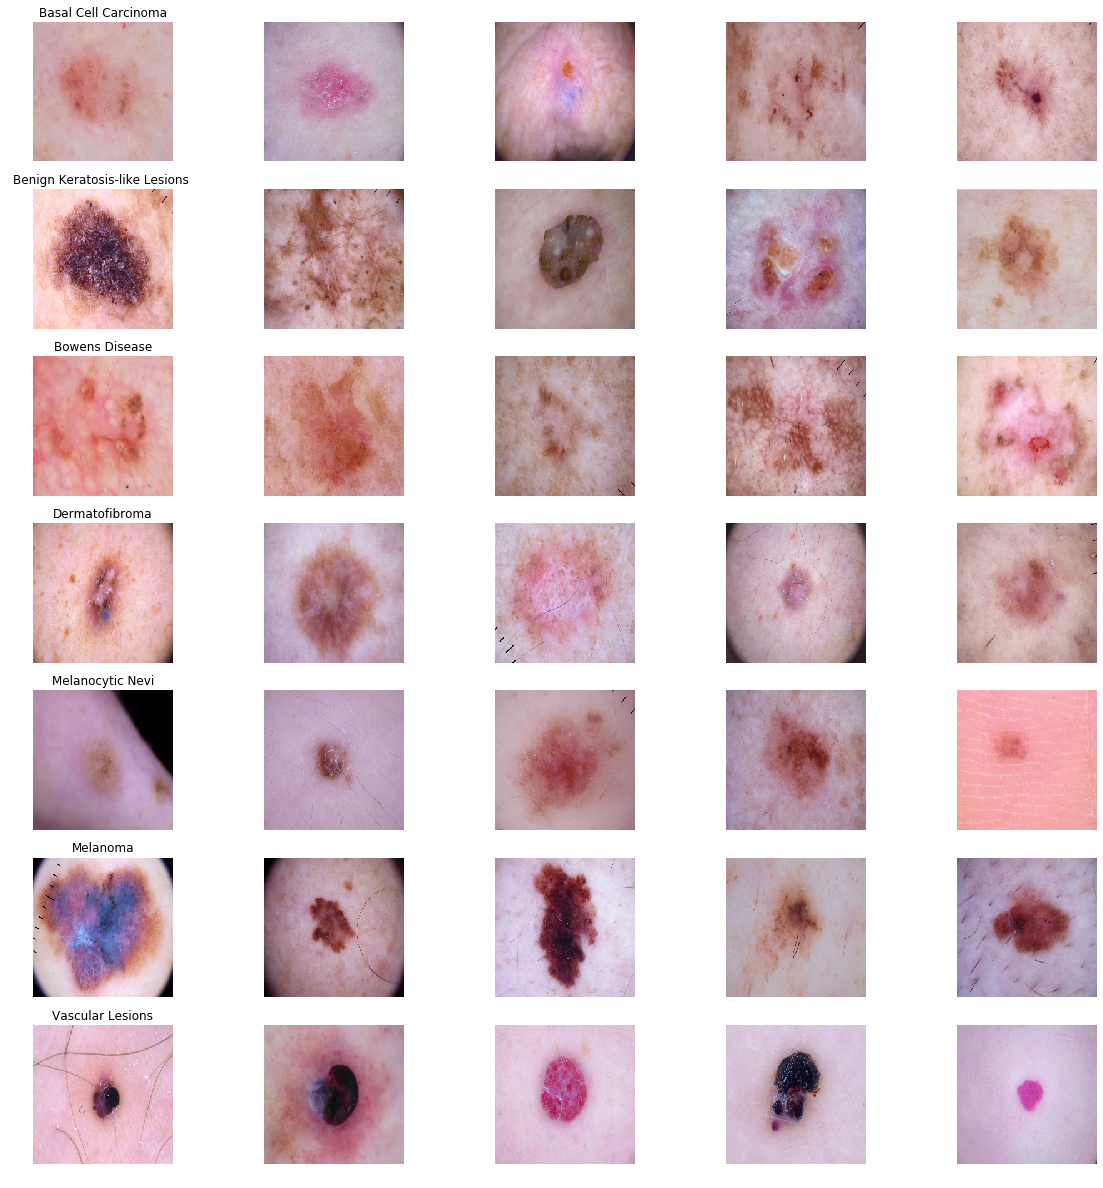

In [41]:
# plot the images (Only run this when necessary - yuck)
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [42]:
# get predictor variables and add them to a dataframe
predictor = metadata_df.drop(columns=['cell_type_id'],axis=1)
# get response variables and add them to a series
response = metadata_df['cell_type_id']

In [43]:
# create training and test data for x and y variables at a 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=1)

Data was normalised to

In [44]:
# normalise data
x_train = np.asarray(x_train["image"].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train = (x_train - np.mean(x_train)) / (np.std(x_train))
x_test = (x_test - np.mean(x_test) / np.std(x_test))

<p>One hot encoding was performed on the labels in order to allow the models to bypass the issue of categorical values.</p>

In [45]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [46]:
# split data into training and validation data set at a 70:30 ratio
#x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.3, random_state = 1)

In [48]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3) CNN
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

# reshape images for VGG
#x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
#x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

<h3>Convolutional Neural Network</h3>

In [36]:
# set the model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
nClasses = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'same',activation='relu',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3),padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

<h3>VGG Neural Network</h3>

In [49]:
input_shape = (224, 224, 3)

model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
           activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 256)       295168    
__________

In [50]:
# compile the model

# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [51]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

<p>Data augmentation is used to prevent overfitting. As the dataset is not particularly large, data augmentation helps to prevent overfitting by generating relevant </p>

In [52]:
# data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [40]:
# train the model CNN RESULTS
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
751/751 [==============================] - 19s 25ms/step - loss: 1.0461 - acc: 0.6671 - val_loss: 3.3447 - val_acc: 0.6510 loss: 1.08
Epoch 2/50
751/751 [==============================] - 16s 22ms/step - loss: 0.9116 - acc: 0.6768 - val_loss: 4.8828 - val_acc: 0.5755: 8s - loss: 0.9189 - acc: 0.682 - ETA: 8s - loss: 
Epoch 3/50
751/751 [==============================] - 16s 22ms/step - loss: 0.8651 - acc: 0.6846 - val_loss: 7.1509 - val_acc: 0.3798
Epoch 4/50
751/751 [==============================] - 16s 22ms/step - loss: 0.8587 - acc: 0.6885 - val_loss: 5.4212 - val_acc: 0.6625
Epoch 5/50
751/751 [==============================] - 16s 22ms/step - loss: 0.8433 - acc: 0.7008 - val_loss: 4.1900 - val_acc: 0.5220: 0.8417 - acc: 0.7 - ETA: 0s - loss: 0.8420 - acc: 0.
Epoch 6/50
751/751 [==============================] - 16s 22ms/step - loss: 0.8182 - acc: 0.7043 - val_loss: 7.9440 - val_acc: 0.4081
Epoch 7/50
751/751 [==============================] - 16s 22ms/step - loss: 0.80

In [ ]:
# train the model VGG RESULTS
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
751/751 [==============================] - 203s 271ms/step - loss: 5.2930 - acc: 0.6706 - val_loss: 5.4263 - val_acc: 0.6633
Epoch 2/50
751/751 [==============================] - 192s 256ms/step - loss: 5.2797 - acc: 0.6724 - val_loss: 5.4263 - val_acc: 0.6633
Epoch 3/50
751/751 [==============================] - 192s 255ms/step - loss: 5.3054 - acc: 0.6708 - val_loss: 5.4263 - val_acc: 0.6633
Epoch 4/50
547/751 [====================>.........] - ETA: 48s - loss: 5.3570 - acc: 0.6676

In [99]:
from keras.models import Sequential 
from keras.layers import Dense, Activation 
output_dim = nb_classes = 10 
model = Sequential() 
model.add(Dense(output_dim, input_dim=input_dim, activation='softmax')) 
batch_size = 128 
nb_epoch = 20

C:\Users\b5034806\AppData\Local\Continuum\anaconda3\envs\MLEnv2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Found array with dim 4. Estimator expected <= 2.

NameError: name 'itertools' is not defined

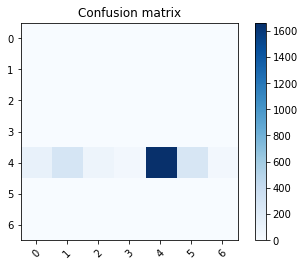

In [88]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test,axis = 1) 

confusion = confusion_matrix(y_pred, y_true)

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion, classes = range(7)) 

In [85]:
y_pred = model.predict(x_test)

In [98]:
print(y_train)

[[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


<h3>Discussion of Results</h3>
<p>While VGG is widely regarded as an excellent machine learning model, in this case it fell off at 0.6665 acuracy after a few epochs.</p>

<h1>References</h1>
<p>Tschandl, P., Rosendahl, C. and Kittler, H. (2018). The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Scientific Data, 5, p.180161.</p>
<p>Howard, J. (2019). fast.ai · Making neural nets uncool again. [online] Fast.ai. Available at: https://www.fast.ai/ [Accessed 22 Jan. 2019].</p>
